In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import matplotlib as mpl
from matplotlib.offsetbox import AnchoredText
import warnings

from src import data, paths, centroids, matrix_filtering

from netneurotools import metrics
    # https://netneurotools.readthedocs.io/en/latest/, pip install netneurotools does not work for me
    # I downloaded the repository and I am using the local copy

%matplotlib inline

!date -I

2024-05-09


## Settings

In [45]:
parcellations = {"DKT","MNI-HCP-MMP1"} # MNI-HCP-MMP1 is another name for Glasser parcellation

# following ROIs are not present in enigma with DKT parcellation,
# so it should be deleted from responses to have matching dimensions
ids_to_delete_in_dkt = [37,3] 

# set parecallation to use for structural connectivity
# availible parcellations listed above
PARCELLATION = "MNI-HCP-MMP1"
AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK = False

# True for 50 ms version, 200 ms version otherwise
FTRACT_SHORT = True

ED_threshold = 20
min_streamlines = 5
graph_density = 0.25

if PARCELLATION not in parcellations:
    print(f"Selected parcellation {PARCELLATION} not in availible parcellations!")

In [46]:
fig_dir = f"ftract_results/{PARCELLATION}/{min_streamlines}/ED{ED_threshold}/{graph_density}/{'short' if FTRACT_SHORT else 'long'}/"
%mkdir -p  {paths.path_figures(fig_dir)}

## Load data

### Load F-TRACT data

In [47]:
# F-TRACT dataset is availible in several parcellations, select and load the one defined above
response_probability, response_amplitude, response_onset_delay, response_peak_delay, n_stim, n_impl, ftract_labels = data.load_ftract(PARCELLATION,short=FTRACT_SHORT)

if PARCELLATION == "DKT":
    for a in [0,1]:
        response_probability = np.delete(response_probability,ids_to_delete_in_dkt,axis=a)
        response_amplitude = np.delete(response_amplitude,ids_to_delete_in_dkt,axis=a)
        response_onset_delay = np.delete(response_onset_delay,ids_to_delete_in_dkt,axis=a)
        response_peak_delay = np.delete(response_peak_delay,ids_to_delete_in_dkt,axis=a)
        n_stim = np.delete(n_stim,ids_to_delete_in_dkt,axis=a)
        n_impl = np.delete(n_impl,ids_to_delete_in_dkt,axis=a)

### Load Euclidean distances

In [48]:
if PARCELLATION == "DKT":
    ED = centroids.dkt_roi_distances()
    
elif PARCELLATION == "MNI-HCP-MMP1":
    ED = centroids.glasser_roi_distances(ftract_labels=ftract_labels)

### Define mask

In [49]:
mask = np.logical_and(np.logical_and(n_stim > 100, n_impl > 5),ED>ED_threshold)

if AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK:
    mask_amp = mask
else:
    mask_amp = (n_stim*response_probability)>=100

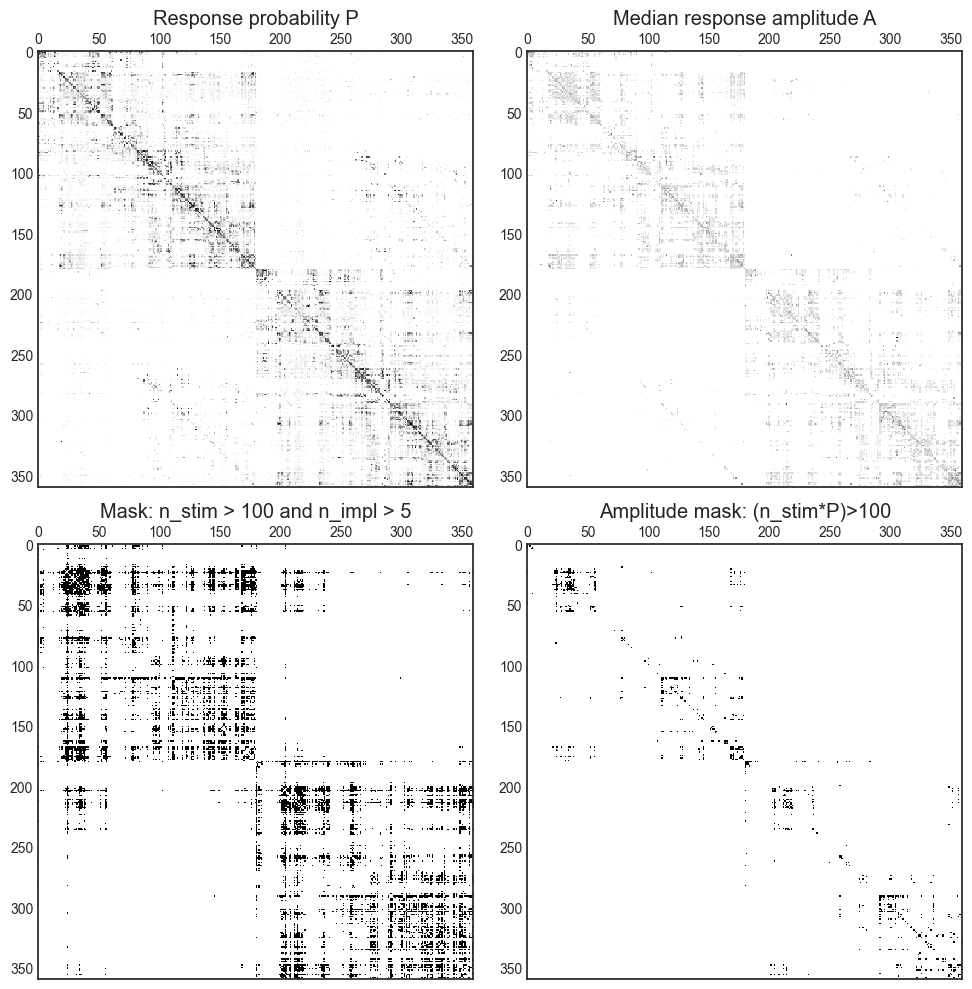

In [50]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.style.use('seaborn-v0_8-white')

fig, axs = plt.subplots(2, 2, tight_layout=True)
axs[0,0].matshow(response_probability)
axs[0,0].set_title("Response probability P")
axs[0,1].matshow(np.log(response_amplitude))
axs[0,1].set_title("Median response amplitude A")
axs[1,0].matshow(mask)
axs[1,0].set_title("Mask: n_stim > 100 and n_impl > 5")
axs[1,1].matshow(mask_amp)

if AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK:
    axs[1,1].set_title("Amplitude mask same as mask")
else:
    axs[1,1].set_title("Amplitude mask: (n_stim*P)>100")

Text(0.5, 1.0, 'Response peak delay PD')

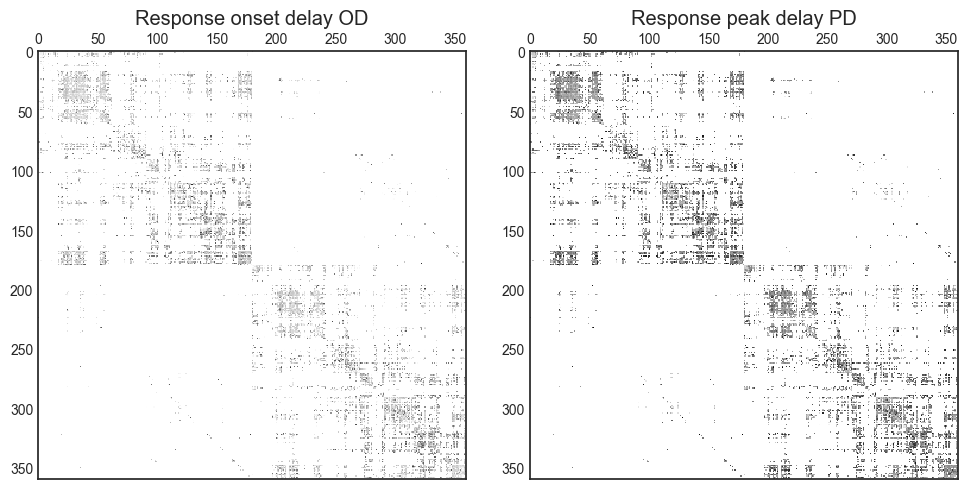

In [51]:
plt.rcParams['figure.figsize'] = [10,5]
plt.style.use('seaborn-v0_8-white')

fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].matshow(response_onset_delay)
axs[0].set_title("Response onset delay OD")
axs[1].matshow(response_peak_delay)
axs[1].set_title("Response peak delay PD")

### Load structural connectivity data

In [31]:
SC_matrices = []

if PARCELLATION == "DKT":
    ED = centroids.dkt_roi_distances()
    SC_matrices = data.load_set_of_DKT_matrices_for_ftract(ids_to_delete_in_dkt,ED,min_streamlines_count=min_streamlines)
    

elif PARCELLATION == "MNI-HCP-MMP1":
    ED = centroids.glasser_roi_distances(ftract_labels=ftract_labels)
    SC_matrices = data.load_set_of_glasser_matrices_for_ftract(ED,min_streamlines_count=min_streamlines)

number_of_SC = len(SC_matrices)

load domhof
load domhof
load domhof


/home/katterrina/fi_muni/0_diplomka/src/data.py:55: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append((f"{dataset_name}_{mode}",SC_W, SC_L,np.log(SC_W)))


In [32]:
SC_matrices_filtered = []

for i, stat_data in enumerate(SC_matrices):
    name, SC_W, SC_L, SC_W_log = stat_data
    pivot = matrix_filtering.find_pivot_to_keep_xpercent_edges(SC_W,graph_density)
    SC_W = np.where(SC_W>=pivot,SC_W,0)
    if SC_L is not None:
        SC_L = np.where(SC_W>=pivot,SC_L,np.nan)
    SC_W_log = np.where(SC_W>=pivot,SC_W_log,np.nan)
    SC_matrices_filtered.append((name, SC_W, SC_L, SC_W_log))

SC_matrices = SC_matrices_filtered

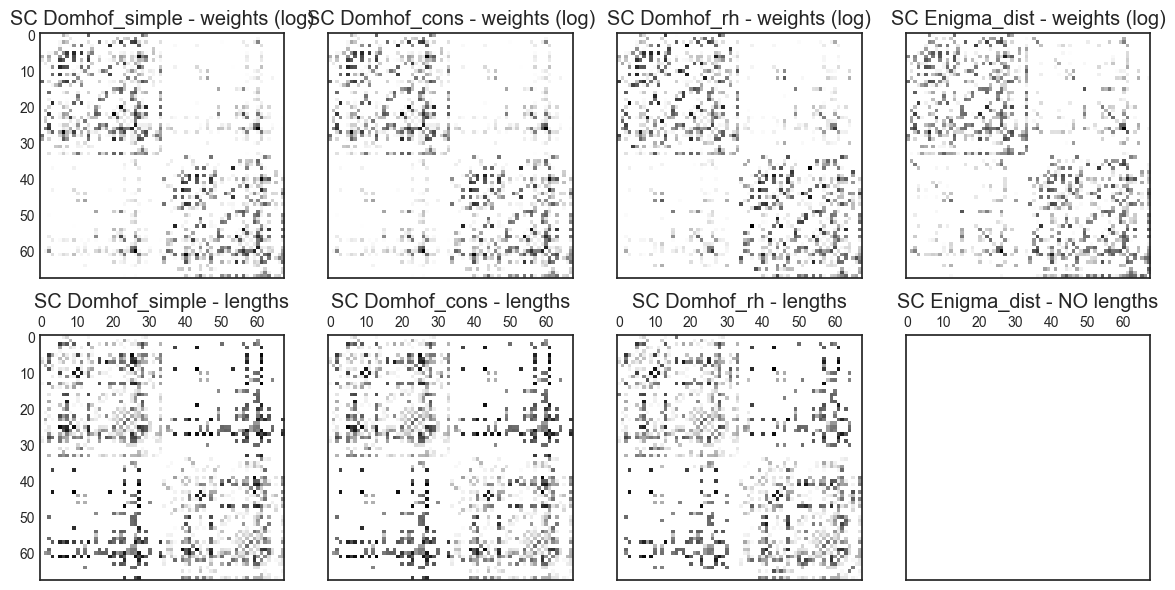

In [33]:
plt.rcParams['figure.figsize'] = [3*number_of_SC,6]
plt.style.use('seaborn-v0_8-white')

fig, axs = plt.subplots(2,number_of_SC, tight_layout=True,sharex=True,sharey=True)

for i, stat_data in enumerate(SC_matrices):
    name, SC_W, SC_L, SC_W_log = stat_data

    axs[0,i].matshow(SC_W_log)
    axs[0,i].set_title(f"SC {name} - weights (log)")

    if SC_L is not None:
        axs[1,i].matshow(SC_L)
        axs[1,i].set_title(f"SC {name} - lengths")

    else:
        axs[1,i].matshow(np.zeros(SC_W.shape))
        axs[1,i].set_title(f"SC {name} - NO lengths")

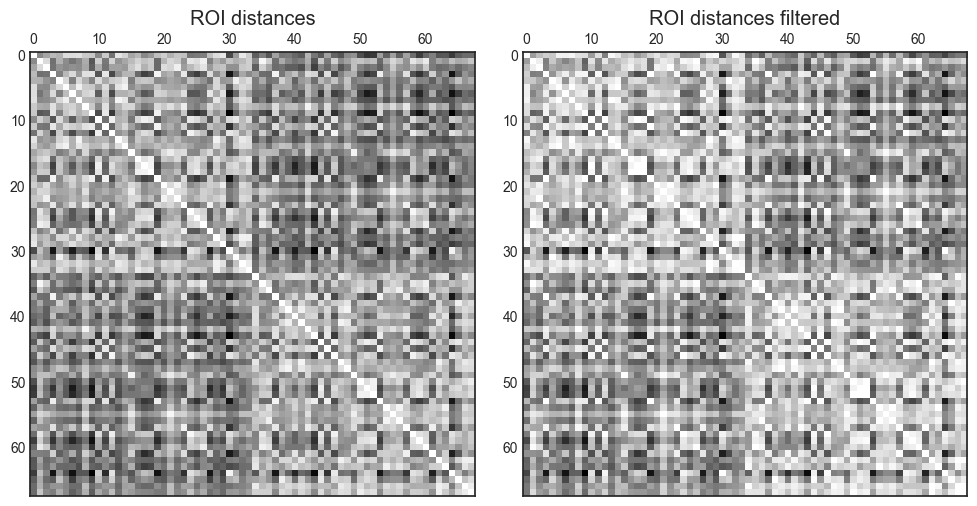

In [34]:
if ED is not None:
    fig, axs = plt.subplots(1, 2, tight_layout=True,figsize=(10,5))

    axs[0].matshow(ED)
    axs[0].set_title("ROI distances")
    ED_filtered = np.where(ED>ED_threshold,ED,np.nan)
    axs[1].matshow(ED_filtered)
    axs[1].set_title("ROI distances filtered")
    plt.show()

## Correlations

In [35]:
def calculate_communicatin_metrics(ED,SC_L,SC_W,name=None):
    metrics_dict = dict()

    metrics_dict["ED"] = ED
    metrics_dict["SC_W"] = SC_W
    
    if SC_L is not None:
        metrics_dict["SC_L"] = SC_L

    # shortest path efficiency
    if SC_L is not None:
            shortest_paths,_ = metrics.distance_wei_floyd(SC_L)
            metrics_dict["SPE"] = np.divide(1,shortest_paths)
    # else:
    #     print(f"Edge lengths not availible for {name}, 1/SC_W used for SPE instead")
    #     shortest_paths,_ = metrics.distance_wei_floyd(1/SC_W)
    #     metrics_dict["SPE"] = np.divide(1,shortest_paths)

    # shortest path efficiency using weights
    shortest_paths,_ = metrics.distance_wei_floyd(1/SC_W)
    metrics_dict["SPE_W"] = np.divide(1,shortest_paths)

    # communicability
    metrics_dict["COM"] = metrics.communicability_wei(np.nan_to_num(SC_W,nan=0))

    # SI
    metrics_dict["SI"] = metrics.search_information(SC_W,ED)

    # SI with length
    if SC_L is not None:
         metrics_dict["SI_L"] = metrics.search_information(SC_W,SC_L)

    # navigation path eff.
    _,_,nav_paths,_,_ = metrics.navigation_wu(ED, SC_W)
    metrics_dict["NAV"] = np.divide(1,nav_paths)
    
    # navigation path eff. with L
    if SC_L is not None:
        _,_,_,_,nav_paths = metrics.navigation_wu(ED, SC_W)
        nav_paths = metrics.get_navigation_path_length(nav_paths, SC_L)
        metrics_dict["NAV"] = np.divide(1,nav_paths)


    # _, metrics_dict["DIF"] = metrics.diffusion_efficiency(SC_W)
    
    return metrics_dict

def fill_df(df,mask,metrics_dict):

    for m in metrics_dict:
        matrix = metrics_dict[m]
        df[m] = matrix[mask].flatten()

In [36]:
stat_data = {}

for name, SC_W, SC_L, SC_W_log in SC_matrices:
    # this is necessary to supress warnings for some types of matrices
    if SC_L is not None:
        SC_L = np.ascontiguousarray(SC_L)
    SC_W = np.ascontiguousarray(SC_W)

    # supress warnings - all the warnings we saw were about zero division,
    # they result into nans in matrices, but they can not cause any issues
    # (we checked the code where the warnings occured)
    with warnings.catch_warnings(): 
        warnings.simplefilter('ignore')
        metrics_dict = calculate_communicatin_metrics(ED,SC_L,SC_W,name)

    df_probability = pd.DataFrame({"response_probability":response_probability[mask].flatten()})
    df_amplitude = pd.DataFrame({"response_amplitude":response_amplitude[mask_amp].flatten()})
    df_onset_delay = pd.DataFrame({"response_onset_delay":response_onset_delay[mask].flatten()})
    df_peak_delay = pd.DataFrame({"response_peak_delay":response_peak_delay[mask].flatten()})

    fill_df(df_probability,mask,metrics_dict)
    fill_df(df_amplitude,mask_amp,metrics_dict)
    fill_df(df_onset_delay,mask,metrics_dict)
    fill_df(df_peak_delay,mask,metrics_dict)

    stat_data[name] = {"probability":df_probability,"amplitude":df_amplitude,"onset_delay":df_onset_delay,"peak_delay":df_peak_delay}

In [37]:
def partial_corr_ED(d,x,method):
    result = []
    result.append(pd.DataFrame({"n":[0],"r":[0],"CI95%":[None],"p-val":[1],"Y":["ED"]})) # just to have fitting images

    for k in d.keys():
        if k == "ED" or k == x or np.sum(pd.notna(d[x]))<=2 or np.sum(pd.notna(d[k]))<=2:
            continue
        df_one_result = pg.partial_corr(data=d,x=x,y=k,covar="ED", method=method)
        df_one_result['Y'] = k
        result.append(df_one_result)
    
    return pd.concat(result)

In [38]:
keys = []

result_p = []
result_p_partial = []

result_a = []
result_a_partial = []

result_od = []
result_od_partial = []

result_pd = []
result_pd_partial = []

for name,_,_,_ in SC_matrices:
    keys.append(name)
    result_p.append(pg.pairwise_corr(stat_data[name]["probability"],columns=["response_probability"], method='spearman').round(3))
    result_a.append(pg.pairwise_corr(stat_data[name]["amplitude"],columns=["response_amplitude"], method='spearman').round(3))
    if PARCELLATION != "DKT":
        result_od.append(pg.pairwise_corr(stat_data[name]["onset_delay"],columns=["response_onset_delay"], method='spearman').round(3))
        result_pd.append(pg.pairwise_corr(stat_data[name]["peak_delay"],columns=["response_peak_delay"], method='spearman').round(3))
    
    result_p_partial.append(partial_corr_ED(stat_data[name]["probability"],'response_probability',"spearman"))
    result_a_partial.append(partial_corr_ED(stat_data[name]["amplitude"],"response_amplitude","spearman"))  
    if PARCELLATION != "DKT":
        result_od_partial.append(partial_corr_ED(stat_data[name]["onset_delay"],"response_onset_delay",'spearman'))
        result_pd_partial.append(partial_corr_ED(stat_data[name]["peak_delay"],"response_peak_delay",'spearman'))

/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/pingouin/power.py:861: UserWarning: Sample size is too small to estimate power (n <= 4). Returning NaN.
  warnings.warn("Sample size is too small to estimate power (n <= 4). Returning NaN.")
/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/pingouin/power.py:861: UserWarning: Sample size is too small to estimate power (n <= 4). Returning NaN.
  warnings.warn("Sample size is too small to estimate power (n <= 4). Returning NaN.")
/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/pingouin/power.py:861: UserWarning: Sample size is too small to estimate power (n <= 4). Returning NaN.
  warnings.warn("Sample size is too small to estimate power (n <= 4). Returning NaN.")
/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/pingouin/effsize.py:153: RuntimeWarning: divide by zero encountered in double_scalars
  se = 1 / np.sqrt(nx - 3)
/home/katterrina/f

In [39]:
if PARCELLATION == "DKT":
    for r in result_p+result_a+result_od+result_pd:
        r['r_abs'] = r['r'].apply(abs)
        r['p_sigf'] = r['p-unc'].apply(lambda x: "*" if x< 0.05 else "")

    for r in result_p_partial+result_a_partial+result_od_partial+result_pd_partial:
        r['r_abs'] = r['r'].apply(abs)
        r['p_sigf'] = r['p-val'].apply(lambda x: "*" if x< 0.05 else "")
else:
    for r in result_p+result_a:
        r['r_abs'] = r['r'].apply(abs)
        r['p_sigf'] = r['p-unc'].apply(lambda x: "*" if x< 0.05 else "")

    for r in result_p_partial+result_a_partial:
        r['r_abs'] = r['r'].apply(abs)
        r['p_sigf'] = r['p-val'].apply(lambda x: "*" if x< 0.05 else "")

result_p = pd.concat(result_p, keys=keys).reset_index(names=["dataset","-"])
result_a = pd.concat(result_a, keys=keys).reset_index(names=["dataset","-"])

result_p_partial = pd.concat(result_p_partial, keys=keys).reset_index(names=["dataset","-"])
result_a_partial = pd.concat(result_a_partial, keys=keys).reset_index(names=["dataset","-"])


if PARCELLATION != "DKT":
    result_od = pd.concat(result_od, keys=keys).reset_index(names=["dataset","-"])
    result_pd = pd.concat(result_pd, keys=keys).reset_index(names=["dataset","-"])

    result_od_partial = pd.concat(result_od_partial, keys=keys).reset_index(names=["dataset","-"])
    result_pd_partial = pd.concat(result_pd_partial, keys=keys).reset_index(names=["dataset","-"])

In [40]:
plt.style.use('ggplot')
# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#E24A33', '#348ABD', '#8EBA42','#FBC15E', '#777777', '#988ED5', '#FFB5B8']) 

In [41]:
def plot_results(d,title):
    plt.figure(figsize=(7,10))
    
    ax = sns.barplot(data=d, x='Y', y='r_abs',hue="dataset")
    ax.set_title(title)  
    ax.set_ylim(bottom=0, top=1)
    ax.tick_params(axis='x', rotation=90)

    plt.xlabel('Communication metric')
    plt.ylabel('Correlation coefficient')

    plt.show()

def plot_results_overlay(d,d_partial,title):
    plt.figure(figsize=(7,10))

    datasets = d["dataset"].unique()
    metrics = d["Y"].unique()

    ax = sns.barplot(data=d, x='Y', y='r_abs',hue="dataset", alpha=0.35,legend=False)

    for i,dataset in enumerate(datasets):
        dataset_container = ax.containers[i]
        j = 0
        for metric in metrics:
            if ((d["dataset"] == dataset) & (d['Y'] == metric)).any():
                significance = d[(d["dataset"] == dataset) & (d['Y'] == metric)]["p_sigf"].values[0]
                bar = dataset_container[j]
                bbox = bar.get_bbox().bounds
                x = bbox[0] + (bbox[2]/2)
                y = bbox[3] + 0.005
                plt.text(x,y,significance,horizontalalignment='center')
                j +=1

    sns.barplot(data=d_partial, x='Y', y='r_abs',hue="dataset",ax=ax)

    for i2,dataset in enumerate(datasets):
        dataset_container = ax.containers[i+i2+1]
        j = 0
        for metric in metrics:
            if ((d_partial["dataset"] == dataset) & (d_partial['Y'] == metric)).any():
                significance = d_partial[(d_partial["dataset"] == dataset) & (d_partial['Y'] == metric)]["p_sigf"].values[0]
                bar = dataset_container[j]
                bbox = bar.get_bbox().bounds
                x = bbox[0] + (bbox[2]/2)
                y = bbox[3] + 0.005
                plt.text(x,y,significance,horizontalalignment='center')
                j +=1

    ax.set_title(title)  
    ax.set_ylim(bottom=0, top=1)
    ax.tick_params(axis='x', rotation=90)

    at = AnchoredText("opaque for partiall correlation\ninfluence of ED controlled",frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

    plt.xlabel('Communication metric')
    plt.ylabel('Correlation coefficient')

    img_name = title.replace("\n"," ")
    img_name = img_name.replace(" ","_")

    image_path = paths.path_figures(fig_dir+img_name+".pdf")
    print(image_path)
    plt.savefig(image_path,bbox_inches='tight',pad_inches=0)

    plt.show()

/home/katterrina/fi_muni/0_diplomka/figures/ftract_results/DKT/5/ED20/0.25/short/Spearman_correlation_of_SC_network_communication_metrics_with_response_probabilities_in_F-Tract.pdf


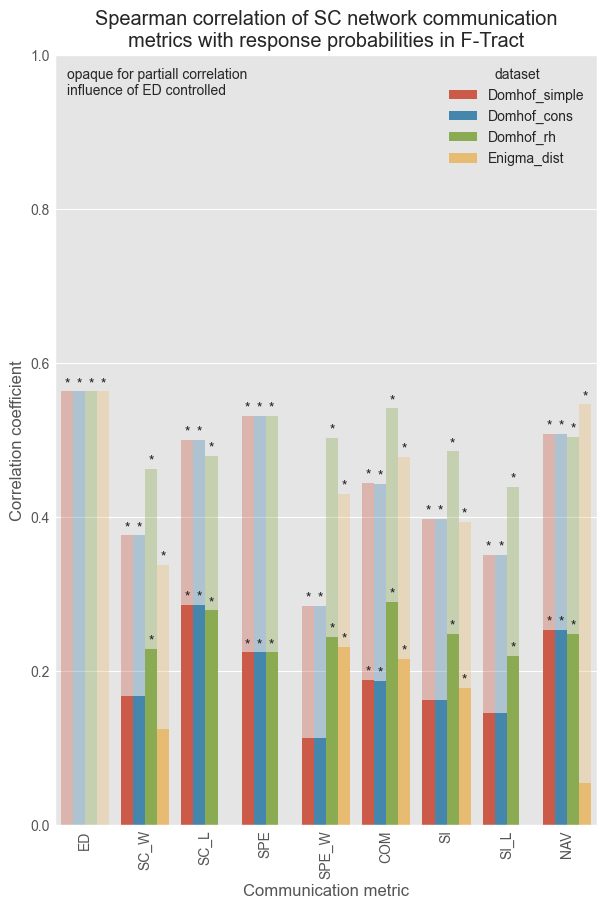

/home/katterrina/fi_muni/0_diplomka/figures/ftract_results/DKT/5/ED20/0.25/short/Spearman_correlation_of_SC_network_communication_metrics_with_response_amplitudes_in_F-Tract.pdf


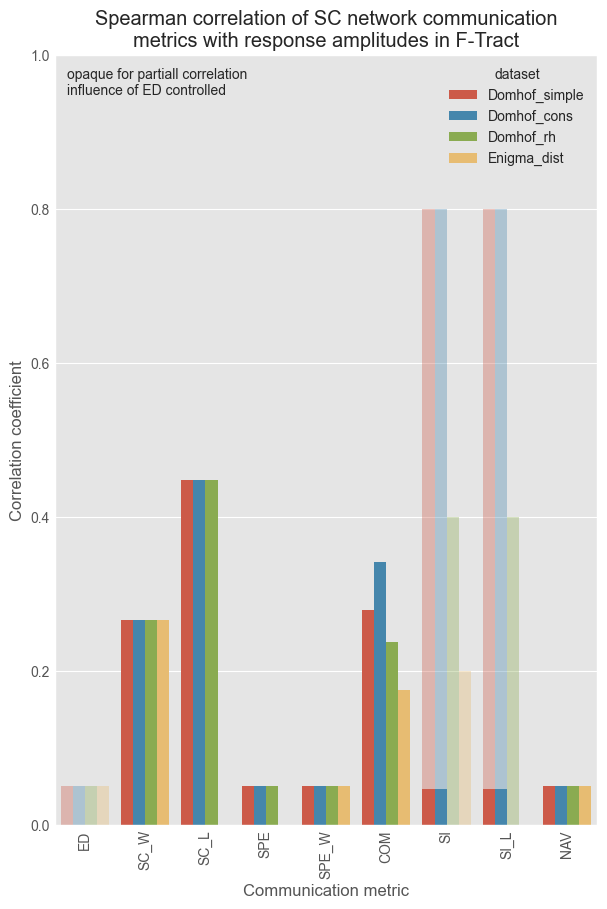

In [42]:
plot_results_overlay(result_p,result_p_partial,title="Spearman correlation of SC network communication\nmetrics with response probabilities in F-Tract")
plot_results_overlay(result_a,result_a_partial,title="Spearman correlation of SC network communication\nmetrics with response amplitudes in F-Tract")

In [43]:
if PARCELLATION != "DKT":
    plot_results_overlay(result_od,result_od_partial,title="Spearman correlation of SC network communication\nmetrics with response onset delay in F-Tract")
    plot_results_overlay(result_pd,result_pd_partial,title="Spearman correlation of SC network communication\nmetrics with response peak delay in F-Tract")

In [44]:
# plot_results(result_p,title="Spearman correlation of SC network communication\nmetrics with response probability in F-Tract")
# plot_results(result_p_partial,title="Partial spearman correlation of SC network communication\nmetrics with response probability in F-Tract (ED controlled)")
# plot_results(result_a,title="Spearman correlation of SC network communication\nmetrics with response amplitude in F-Tract")
# plot_results(result_a_partial,title="Partial spearman correlation of SC network communication\nmetrics with response amplitude in F-Tract (ED controlled)")